In [250]:
using JuMP, Ipopt, Plots
using Images, QuartzImageIO, ImageView

In [251]:
dynopt_batch = Model(solver=IpoptSolver());

In [252]:
np       = 1:101        # number of discretization points
t        = 150+273.16   # K
a1       = 0.7e1        # L/(mol-min)
e1       = 2000         # cal/mol
a2       = 2.5e02       # 1/min
e2       = 9500         # cal/mol
rgas     = 1.987        # cal/(mol-K)
v        = 5000         # L

t0       = 0            # initial time [min]
tf       = 20*60        # end time
na_init  = 100          # Number of initial moles of compound A
nb_init  = 0            # Number of initial moles of compound B
nc_init  = 0            # Number of initial moles of compound C
t_init   = 30+273.16    # Initial reactor temperature [k]
t_max    = 200+273.16   # Maximum reaction temperature [K]
alpha1   = 1            # weighting factor
alpha2   = 1            # weighting factor

1

In [253]:
time  = Array{Float64}(undef, length(np))
w     = Array{Float64}(undef, length(np))
dt    = (tf-t0)/(length(np)-1)
for i = 1:length(np)
   time[i] = t0+(i-1)*dt
end
w[1] = 1
w[length(np)] = 1;
for i = 2:length(np)-1
    w[i] = 2
    if mod(i,2) == 0
       w[i] = 3
    end
end

In [254]:
@variable(dynopt_batch, 0      <= na[np]  <= na_init,    start = 0.5*na_init)
@variable(dynopt_batch,           nb[np]  >= 0      ,    start = 0.5*na_init)
@variable(dynopt_batch,           nc[np]  >= 0      ,    start = 0.5*na_init)
@variable(dynopt_batch, t_init <= t[np]   <= t_max  ,    start = t_init     );

In [255]:
@constraint(dynopt_batch, icond_na, na[1] == na_init)
@constraint(dynopt_batch, icond_nb, nb[1] == nb_init)
@constraint(dynopt_batch, icond_nc, nc[1] == nc_init)
@constraint(dynopt_batch, icond_tr, t[1]  == t_init );

In [256]:
@NLconstraint(dynopt_batch, dynmodel_na[i in 2:length(np)], 
  na[i] == na[i-1] + dt*( -a1*exp(-e1/(rgas*t[i]))*(na[i]/v)^2*v ) ) ;

In [257]:
@NLconstraint(dynopt_batch, dynmodel_nb[i in 2:length(np)], 
  nb[i] == nb[i-1] + dt*( a1*exp(-e1/(rgas*t[i]))*(na[i]/v)^2*v - a2*exp(-e2/(rgas*t[i]))*(nb[i]/v)*v   ) ) ;

In [258]:
@NLconstraint(dynopt_batch, dynmodel_nc[i in 2:length(np)], 
  nc[i] == nc[i-1] + dt*( a2*exp(-e2/(rgas*t[i]))*(nb[i]/v)*v ) ) ;

In [259]:
@NLobjective(dynopt_batch, Max, 
#    (dt/3)*sum(w[i]*( alpha2*(nb[i]^2 )) for i in np   )  );
(dt/3)*sum(w[i]*( -alpha1*(nc[i])^2 + alpha2*(nb[i]^2 )) for i in np   )  );
#(dt/3)*sum(w[i]*( -alpha1*(na[i])^2 -alpha1*(nc[i])^2 + alpha2*(nb[i]^2 )) for i in np   )  );

In [260]:
status_dynopt_batch = solve(dynopt_batch);

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1104
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1302

Total number of variables............................:      404
                     variables with only lower bounds:      202
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [261]:
println("Objective function value = ", getobjectivevalue(dynopt_batch))

Objective function value = 4.9826949863175955e6


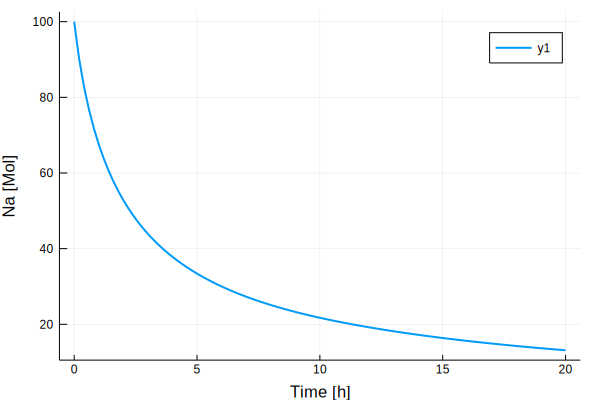

In [262]:
timep    = Array{Float64}(undef, length(np))                
nap      = Array{Float64}(undef, length(np))                
nbp      = Array{Float64}(undef, length(np))                
ncp      = Array{Float64}(undef, length(np))                
trp      = Array{Float64}(undef, length(np))                

for i = 1:length(np)
    timep[i] = time[i]/60
    nap[i]   = getvalue(na[i])   
    nbp[i]   = getvalue(nb[i])   
    ncp[i]   = getvalue(nc[i])   
    trp[i]   = getvalue(t[i])-273.16   
end    

plot(timep,nap,lw=2,xlabel="Time [h]",ylabel="Na [Mol]")

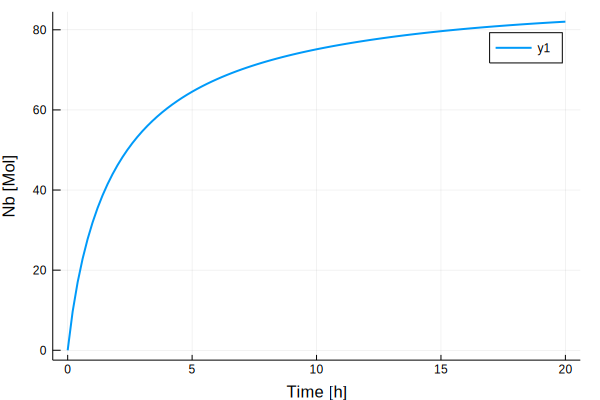

In [263]:
plot(timep,nbp,lw=2,xlabel="Time [h]",ylabel="Nb [Mol]")

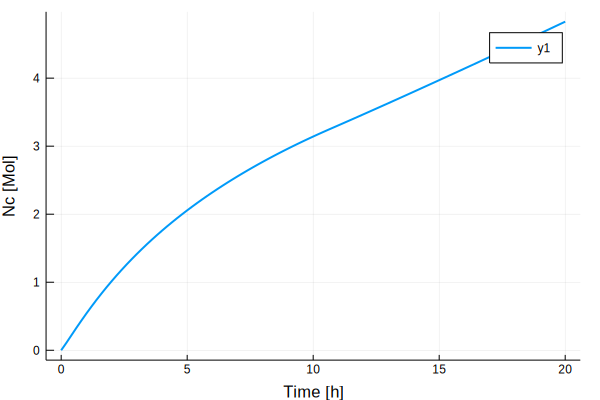

In [264]:
plot(timep,ncp,lw=2,xlabel="Time [h]",ylabel="Nc [Mol]")

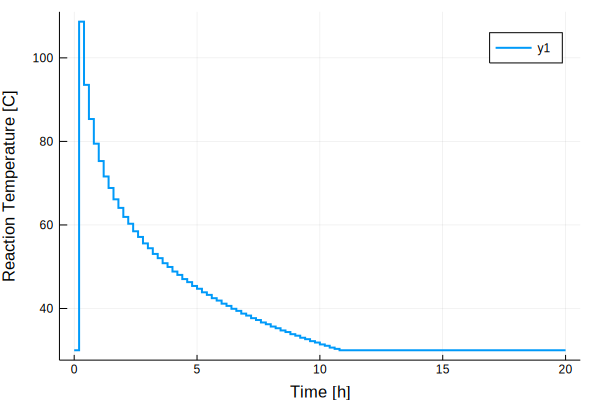

In [265]:
plot(timep,trp,lw=2,linetype=:steppost,xlabel="Time [h]",ylabel="Reaction Temperature [C]")